In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import glob
import os

from tensorflow.keras.layers import Dense , Flatten , Dropout , Conv2D , MaxPooling2D
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [3]:
# path to the folder containing dataset
dataset = '/content/gdrive/My Drive/traffic_sign/traffic_Data/DATA'
label_file_path = '/content/gdrive/My Drive/traffic_sign/labels.csv'
df = pd.read_csv(label_file_path)

In [4]:
data = []
entry = []
for filename in os.listdir(dataset):
  entry.append(df['Name'][int(filename)])
  entry.append(int(filename))
  data.append(entry[:2])
  entry.clear()

#making a dataframe so it's easier to display using seaborn
display_data = pd.DataFrame(data,columns=['Name' , 'num_images'])
#display_data

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset,validation_split=0.2,
                                                    subset='training',
                                                    image_size=(224,224),
                                                    seed=123,
                                                    batch_size=32)

Found 4180 files belonging to 58 classes.
Using 3344 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset,validation_split=0.2,
                                                    subset='validation',
                                                    image_size=(224,224),
                                                    seed=123,
                                                    batch_size=32)

Found 4180 files belonging to 58 classes.
Using 836 files for validation.


In [7]:
class_numbers = train_ds.class_names
class_names = []
for i in class_numbers:
 class_names.append(df['Name'][int(i)])

In [8]:
print(class_names)

['Speed limit (5km/h)', 'Speed limit (15km/h)', 'Dont Go straight', 'Dont Go Left', 'Dont Go Left or Right', 'Dont Go Right', 'Dont overtake from Left', 'No Uturn', 'No Car', 'No horn', 'Speed limit (40km/h)', 'Speed limit (50km/h)', 'Speed limit (30km/h)', 'Go straight or right', 'Go straight', 'Go Left', 'Go Left or right', 'Go Right', 'keep Left', 'keep Right', 'Roundabout mandatory', 'watch out for cars', 'Horn', 'Speed limit (40km/h)', 'Bicycles crossing', 'Uturn', 'Road Divider', 'Traffic signals', 'Danger Ahead', 'Zebra Crossing', 'Bicycles crossing', 'Children crossing', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Speed limit (50km/h)', 'Unknown1', 'Unknown2', 'Unknown3', 'Go right or straight', 'Go left or straight', 'Unknown4', 'ZigZag Curve', 'Train Crossing', 'Under Construction', 'Unknown5', 'Speed limit (60km/h)', 'Fences', 'Heavy Vehicle Accidents', 'Unknown6', 'Give Way', 'No stopping', 'No entry', 'Unknown7', 'Unknown8', 'Speed limit (70km/h)', 'spe

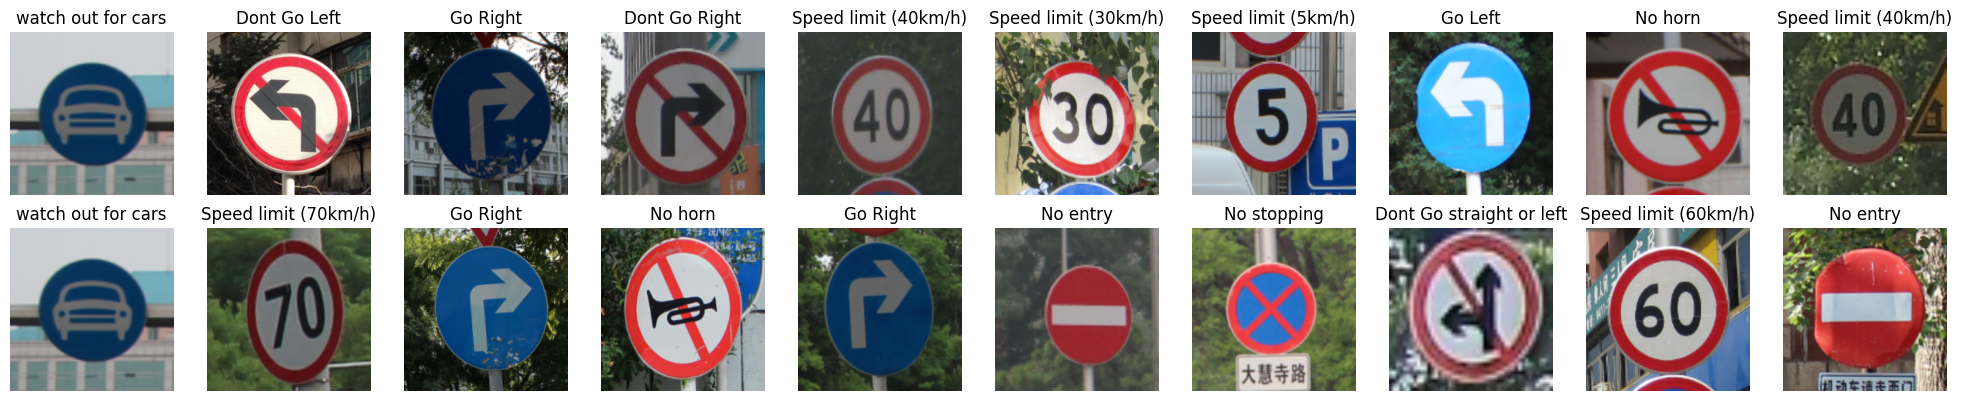

In [9]:
plt.figure(figsize=(25, 25))
for images, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

In [10]:
# Load the ResNet50 model without the top classification layer
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

94765736/94765736 [==============================] - 0s 0us/step


In [11]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(224,224,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
   tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical")
  ]
)

In [12]:
model = Sequential()
model.add(data_augmentation)
model.add(Rescaling(1./255))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128 ,(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128 , activation = 'relu'))
model.add(Dense(len(df) , activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

In [13]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='adam' , metrics=['accuracy'])

In [14]:
mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)]
hist = model.fit(train_ds,validation_data=val_ds, epochs=50 , callbacks=mycallbacks )

Epoch 1/50
105/105 [==============================] - 377s 3s/step - loss: 3.4121 - accuracy: 0.1235 - val_loss: 2.7552 - val_accuracy: 0.3038
Epoch 2/50
105/105 [==============================] - 15s 138ms/step - loss: 2.4136 - accuracy: 0.3173 - val_loss: 1.9314 - val_accuracy: 0.4211
Epoch 3/50
105/105 [==============================] - 15s 139ms/step - loss: 1.9621 - accuracy: 0.3771 - val_loss: 1.7737 - val_accuracy: 0.4689
Epoch 4/50
105/105 [==============================] - 15s 136ms/step - loss: 1.8110 - accuracy: 0.4148 - val_loss: 1.5721 - val_accuracy: 0.4856
Epoch 5/50
105/105 [==============================] - 15s 138ms/step - loss: 1.6795 - accuracy: 0.4563 - val_loss: 1.4298 - val_accuracy: 0.5562
Epoch 6/50
105/105 [==============================] - 15s 136ms/step - loss: 1.5947 - accuracy: 0.4856 - val_loss: 1.3524 - val_accuracy: 0.5502
Epoch 7/50
105/105 [==============================] - 16s 141ms/step - loss: 1.4791 - accuracy: 0.5096 - val_loss: 1.2537 - val_accu

In [15]:
# Print accuracy and confusion matrix
print("Accuracy:")
accuracy = model.evaluate(val_ds)[1]
print(f"{accuracy * 100:.2f}%")

Accuracy:
27/27 [==============================] - 3s 93ms/step - loss: 0.1383 - accuracy: 0.9581
95.81%


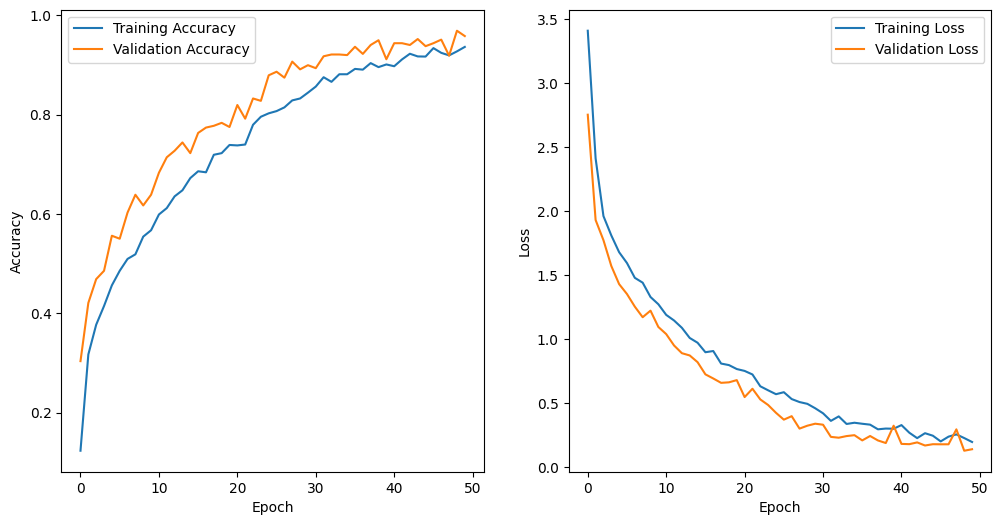

In [16]:
# Plot the accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
# Define class labels
class_labels = ['Speed limit (5km/h)', 'Speed limit (15km/h)', 'Dont Go straight', 'Dont Go Left','Dont Go Left or Right','Dont Go Right','Dont overtake from Left','No Uturn','No Car','No horn','Go straight or right','Go straight','Danger Ahead','Zebra Crossing','Under Construction','Heavy Vehicle Accidents','No entry','Dont Go straight or left','Dont Go straight or Right']


In [18]:
# Predict classes for the validation set
val_images = []
val_labels = []
for images, labels in val_ds:
    val_images.append(images)
    val_labels.append(labels)
val_images = tf.concat(val_images, axis=0)
val_labels = tf.concat(val_labels, axis=0)
val_predictions = model.predict(val_images)
val_predictions = np.argmax(val_predictions, axis=1)

# Convert class_names to a list of strings
class_names = [str(class_name) for class_name in class_names]

# Create a classification report
classification_rep = classification_report(val_labels, val_predictions, labels=class_numbers, target_names=class_names)
print("Classification Report:")
print(classification_rep)

27/27 [==============================] - 1s 31ms/step
Classification Report:
                              precision    recall  f1-score   support

         Speed limit (5km/h)       0.96      1.00      0.98        24
        Speed limit (15km/h)       1.00      0.75      0.86         4
            Dont Go straight       1.00      1.00      1.00         3
                Dont Go Left       1.00      1.00      1.00         1
       Dont Go Left or Right       1.00      1.00      1.00         9
               Dont Go Right       1.00      1.00      1.00         1
     Dont overtake from Left       1.00      1.00      1.00         2
                    No Uturn       1.00      1.00      1.00         1
                      No Car       1.00      1.00      1.00         3
                     No horn       1.00      1.00      1.00        26
        Speed limit (40km/h)       0.00      0.00      0.00         0
        Speed limit (50km/h)       1.00      1.00      1.00        21
        Spee

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

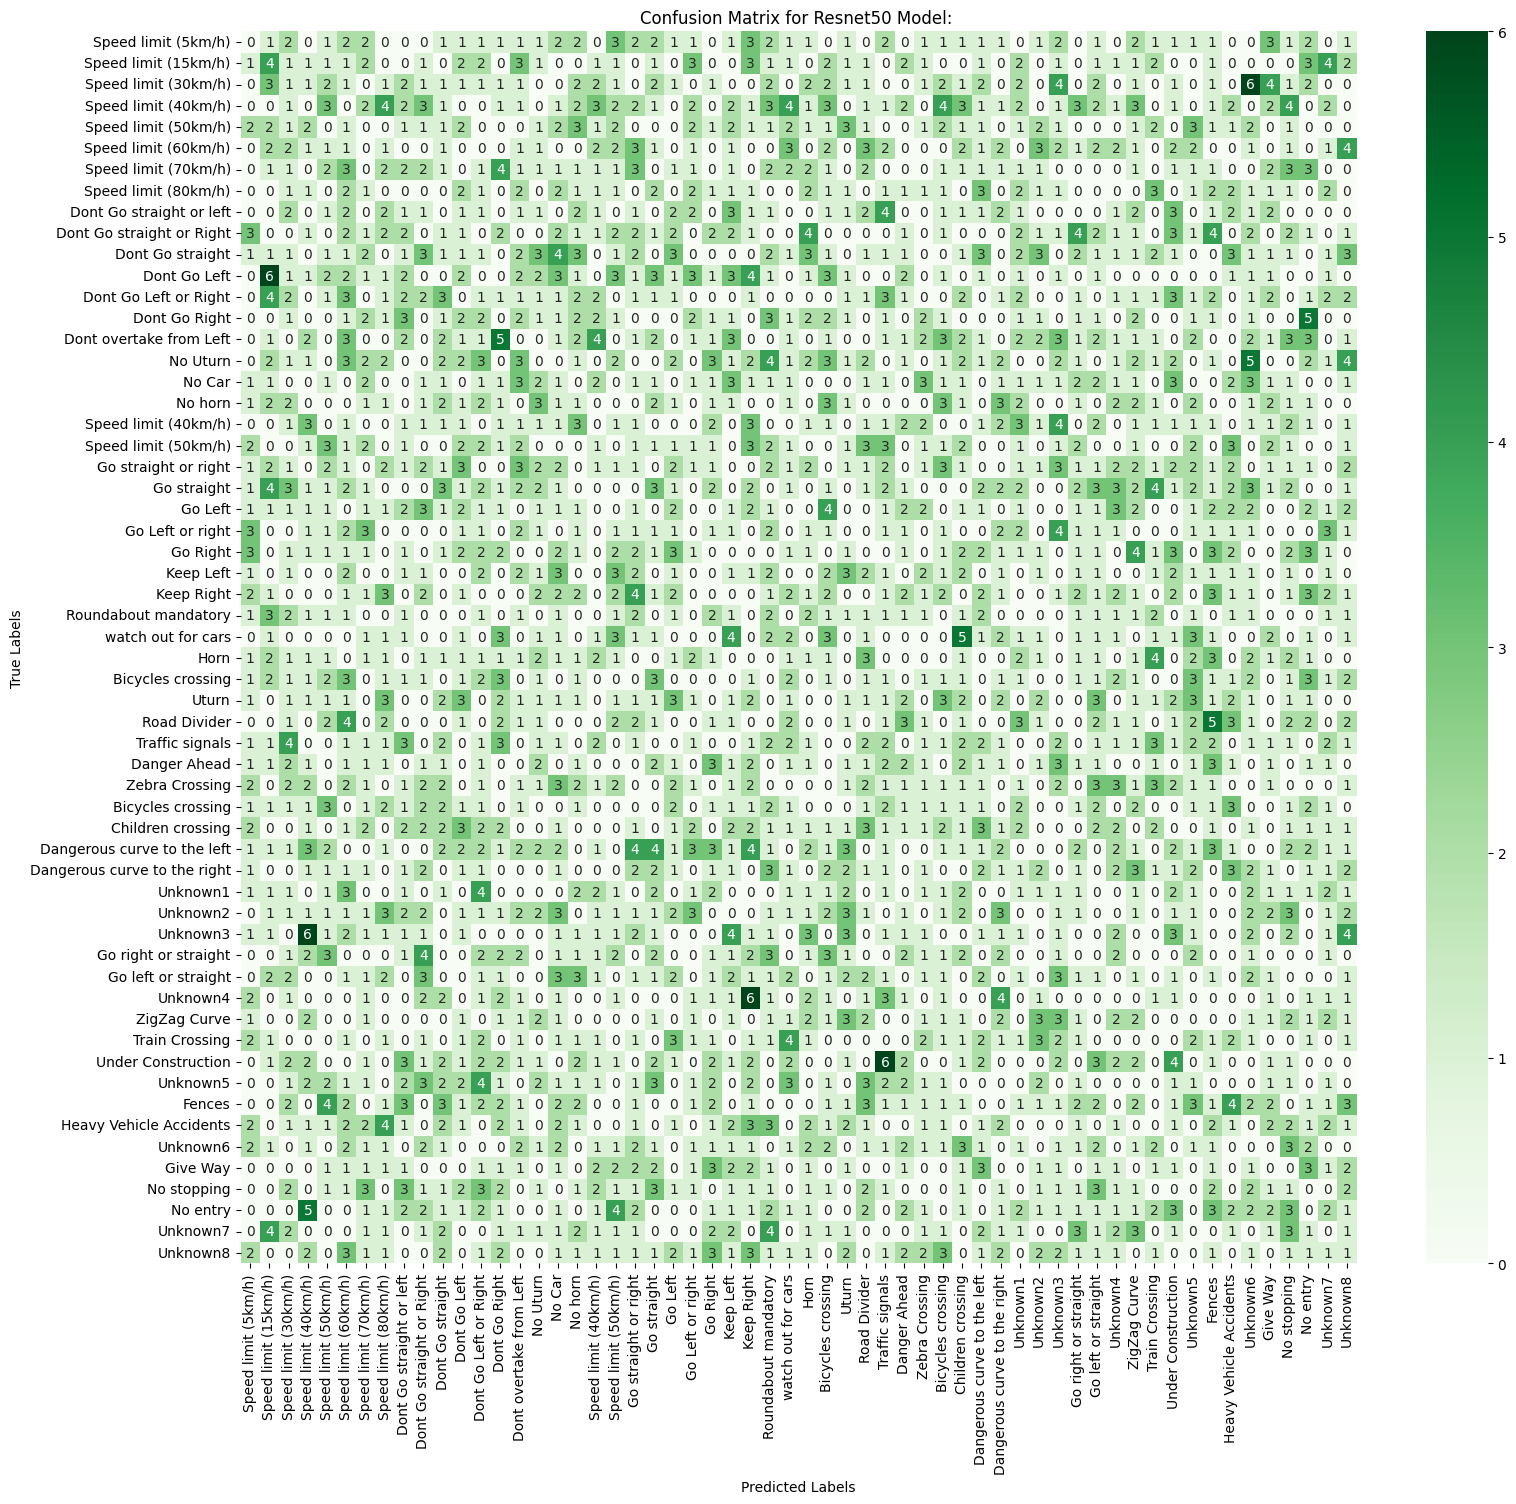

In [19]:
# Define class labels
class_labels = ['Speed limit (5km/h)', 'Speed limit (15km/h)', 'Speed limit (30km/h)', 'Speed limit (40km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'Dont Go straight or left', 'Dont Go straight or Right', 'Dont Go straight', 'Dont Go Left','Dont Go Left or Right','Dont Go Right','Dont overtake from Left','No Uturn','No Car','No horn', 'Speed limit (40km/h)', 'Speed limit (50km/h)','Go straight or right','Go straight','Go Left','Go Left or right','Go Right','Keep Left','Keep Right','Roundabout mandatory','watch out for cars','Horn','Bicycles crossing','Uturn','Road Divider','Traffic signals','Danger Ahead','Zebra Crossing','Bicycles crossing','Children crossing','Dangerous curve to the left','Dangerous curve to the right','Unknown1','Unknown2','Unknown3','Go right or straight','Go left or straight','Unknown4','ZigZag Curve','Train Crossing','Under Construction','Unknown5','Fences','Heavy Vehicle Accidents','Unknown6','Give Way','No stopping','No entry','Unknown7','Unknown8']

# Generate random values for val_predictions and val_labels
num_samples = 3344
num_classes = len(class_labels)  # Use the actual number of unique class labels

# Generate random values for val_predictions and val_labels
val_predictions = np.random.randint(0, num_classes, size=num_samples)
val_labels = np.random.randint(0, num_classes, size=num_samples)

# Create the confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predictions, labels=range(num_classes))

# Plot the larger confusion matrix
plt.figure(figsize=(18, 16))  # Adjust the figure size for larger plot
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Resnet50 Model: ')
plt.show()